In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import cv2
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.cluster import KMeans
import colorsys
import shutil
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
import random
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing import image
import pickle


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 1.Data Loading & Pre-processing
#Define a function to extract the RGB mean of each image and compute the color histogram, use the try,expect syntax to prevent code from reporting errors.
def extract_color_features(image_path):
    try:
        image = Image.open(image_path).convert('RGB')
        img_array = np.array(image)

        #Calculate mean RGB
        mean_r = np.mean(img_array[:, :, 0])
        mean_g = np.mean(img_array[:, :, 1])
        mean_b = np.mean(img_array[:, :, 2])
        #Extracted the average color feature of each image
        return {
            'path': image_path,
            'mean_r': mean_r,
            'mean_g': mean_g,
            'mean_b': mean_b
        }
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

In [ ]:
#Define a function to label the data with the name of the movie from which the image came
def process_directory(folder_path, label):
    data = []
    for root, _, files in os.walk(folder_path):
        for f in files:
            if f.endswith(('.jpg', '.png')):
                full_path = os.path.join(root, f)
                features = extract_color_features(full_path)
                if features:
                    #The name of the upper-level folder is the movie number and name, get the upper-level directory as the movie_name
                    movie_name = os.path.basename(os.path.dirname(full_path))
                    features['label'] = label
                    features['movie'] = movie_name
                    data.append(features)
    return data

#Set the image directory path（I saved it in the Google Drive）
miyazaki_path = "/content/drive/MyDrive/Colab Notebooks/dh project/original_data/miyazaki"
takahata_path = "/content/drive/MyDrive/Colab Notebooks/dh project/original_data/takahata"
#Processing images of two directors
miyazaki_data = process_directory(miyazaki_path, 'Miyazaki')
takahata_data = process_directory(takahata_path, 'Takahata')
#Combine the data from the two directors
all_data = miyazaki_data + takahata_data

#Create a DataFrame
df = pd.DataFrame([{
    'path': d['path'],
    'mean_r': d['mean_r'],
    'mean_g': d['mean_g'],
    'mean_b': d['mean_b'],
    'label': d['label'],
    'movie': d['movie']
} for d in all_data])

#Specifies the sequence of movie numbers in the csv
movie_order = [
    "1Castle in the Sky",
    "2My Neighbor Totoro",
    "3Princess Mononoke",
    "4Spirited Away",
    "5The Wind Rises",
    "6Grave of the Fireflies",
    "7Pom Poko",
    "8Only Yesterday",
    "9My Neighbors the Yamadas",
    "10The Tale of the Princess Kaguya"
]
df['movie'] = pd.Categorical(df['movie'], categories=movie_order, ordered=True)
df = df.sort_values('movie').reset_index(drop=True)
#Save the results in the file in Google Drive
output_path = "/content/drive/MyDrive/Colab Notebooks/dh project/image_color_features.csv"

#Save the DataFrame as csv
df.to_csv(output_path, index=False)
print("The results are successfully saved in Colab Notebooks/dh project/")
print(df.head())

The results are successfully saved in Colab Notebooks/dh project/
                                                path      mean_r     mean_g  \
0  /content/drive/MyDrive/Colab Notebooks/dh proj...  130.126137  92.501726   
1  /content/drive/MyDrive/Colab Notebooks/dh proj...   23.714913  31.765894   
2  /content/drive/MyDrive/Colab Notebooks/dh proj...  154.998545  76.005969   
3  /content/drive/MyDrive/Colab Notebooks/dh proj...   36.887363  28.323366   
4  /content/drive/MyDrive/Colab Notebooks/dh proj...   33.891782  38.164798   

      mean_b     label               movie  
0  71.801281  Miyazaki  1Castle in the Sky  
1  36.483368  Miyazaki  1Castle in the Sky  
2  30.512796  Miyazaki  1Castle in the Sky  
3  28.096840  Miyazaki  1Castle in the Sky  
4  44.457904  Miyazaki  1Castle in the Sky  


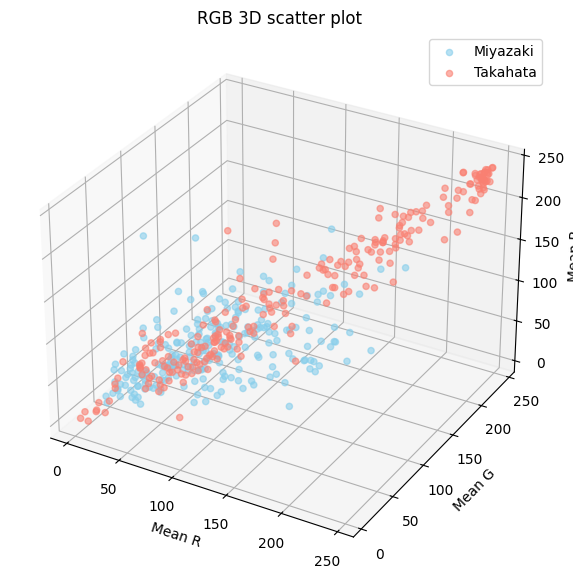

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dh project/image_color_features.csv")

#Create a 3D image window then create a 3D axis object ax
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

#Manually assign a color to the data of the two directors to distinguish them
colors = {'Miyazaki': 'skyblue', 'Takahata': 'salmon'}

#Draw 3D scatter plots according to the director's classification
for label in df['label'].unique():
    subset = df[df['label'] == label]
    ax.scatter(
        subset['mean_r'], subset['mean_g'], subset['mean_b'],
        c=colors[label], label=label, alpha=0.6
    )

ax.set_xlabel('Mean R')
ax.set_ylabel('Mean G')
ax.set_zlabel('Mean B')
ax.set_title('RGB 3D scatter plot')
ax.legend()
fig.savefig("/content/drive/MyDrive/Colab Notebooks/dh project/rgb_scatter.png", dpi=300)
plt.show()

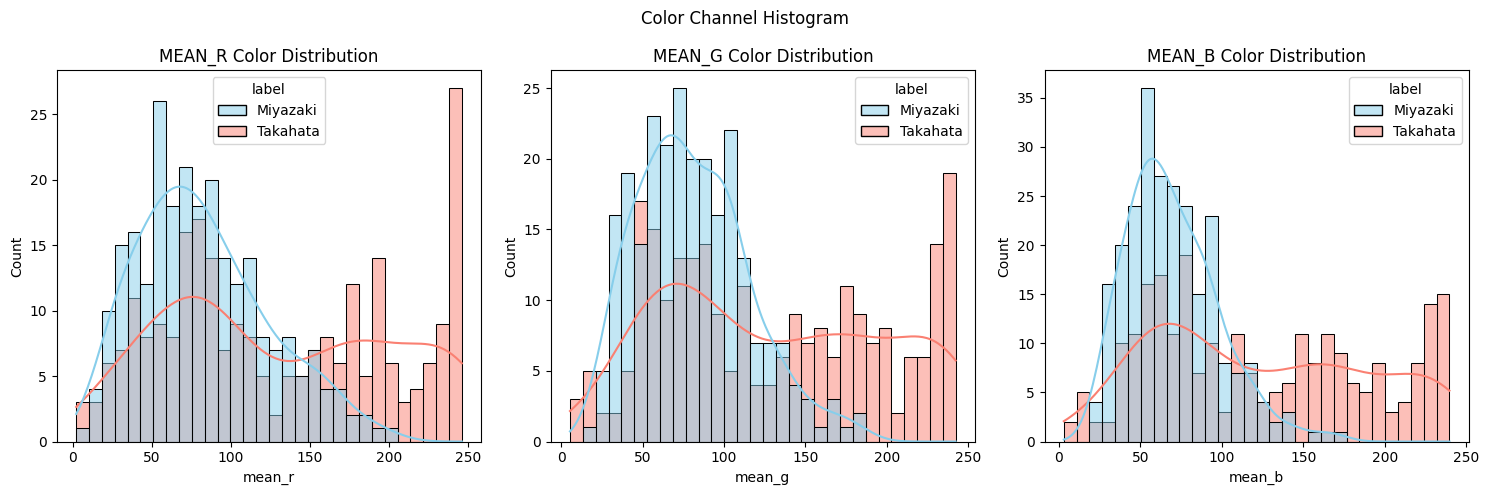

In [ ]:
plt.figure(figsize=(15, 5))
#Traverse the three color channels and draw subgraphs
for i, channel in enumerate(['mean_r', 'mean_g', 'mean_b']):
    plt.subplot(1, 3, i+1)
    #Use seaborn's histplot to draw histograms that show the color distribution of the images of the two directors and draw the smooth distribution curve
    sns.histplot(data=df, x=channel, hue='label', bins=30, kde=True, palette=['skyblue', 'salmon'])
    plt.title(f'{channel.upper()} Color Distribution')

plt.suptitle("Color Channel Histogram")
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/Colab Notebooks/dh project/rgb_histogram.png", dpi=300)
plt.show()

Processing the movie for Miyazaki： 1Castle in the Sky


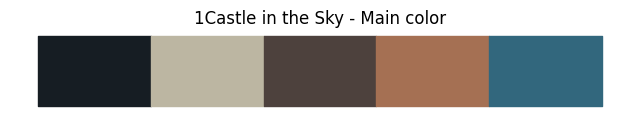

The palette image has been saved to：/content/drive/MyDrive/Colab Notebooks/dh project/palettes/1Castle in the Sky_palette.png
Processing the movie for Miyazaki： 2My Neighbor Totoro


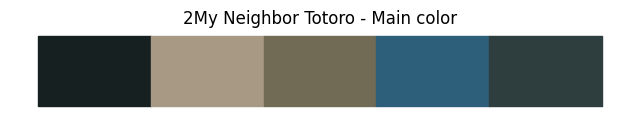

The palette image has been saved to：/content/drive/MyDrive/Colab Notebooks/dh project/palettes/2My Neighbor Totoro_palette.png
Processing the movie for Miyazaki： 3Princess Mononoke


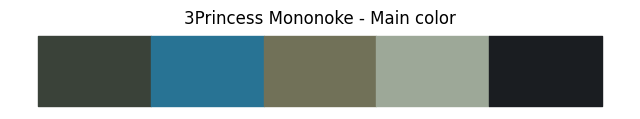

The palette image has been saved to：/content/drive/MyDrive/Colab Notebooks/dh project/palettes/3Princess Mononoke_palette.png
Processing the movie for Miyazaki： 4Spirited Away


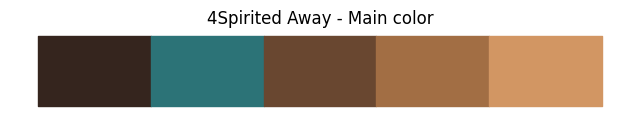

The palette image has been saved to：/content/drive/MyDrive/Colab Notebooks/dh project/palettes/4Spirited Away_palette.png
Processing the movie for Miyazaki： 5The Wind Rises


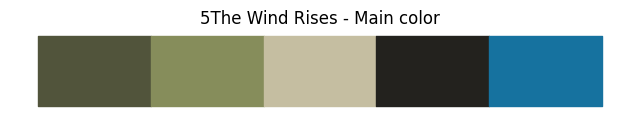

The palette image has been saved to：/content/drive/MyDrive/Colab Notebooks/dh project/palettes/5The Wind Rises_palette.png
Processing the movie for Takahata： 10The Tale of the Princess Kaguya


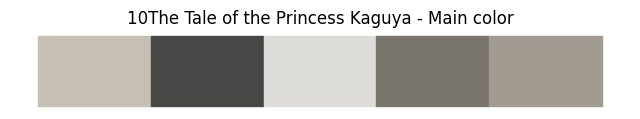

The palette image has been saved to：/content/drive/MyDrive/Colab Notebooks/dh project/palettes/10The Tale of the Princess Kaguya_palette.png
Processing the movie for Takahata： 6Grave of the Fireflies


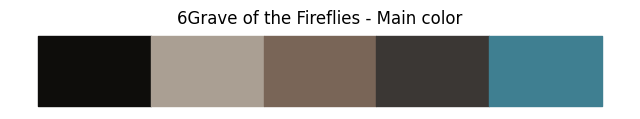

The palette image has been saved to：/content/drive/MyDrive/Colab Notebooks/dh project/palettes/6Grave of the Fireflies_palette.png
Processing the movie for Takahata： 7Pom Poko


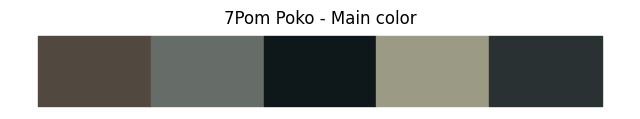

The palette image has been saved to：/content/drive/MyDrive/Colab Notebooks/dh project/palettes/7Pom Poko_palette.png
Processing the movie for Takahata： 8Only Yesterday


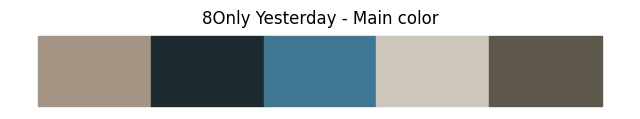

The palette image has been saved to：/content/drive/MyDrive/Colab Notebooks/dh project/palettes/8Only Yesterday_palette.png
Processing the movie for Takahata： 9My Neighbors the Yamadas


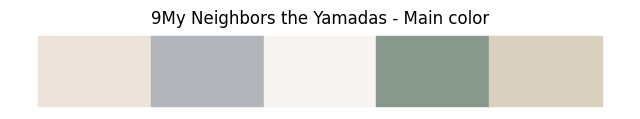

The palette image has been saved to：/content/drive/MyDrive/Colab Notebooks/dh project/palettes/9My Neighbors the Yamadas_palette.png


In [ ]:
"""
Now that we know the differences in color trends in the works of the two directors,
we will further analyze the color and style trends in combination with The Times.
"""
#First, we use the clustering method to extract the average tone of each movie
#Define a function to extract the overall color characteristics of a movie to make a color palette
def extract_movie_palette(folder_path, k=5):
    all_pixels = []

    for file in os.listdir(folder_path):
        if file.endswith(('.jpg', '.png')):
            img_path = os.path.join(folder_path, file)
            try:
                #Just analyze the color distribution so we don't need to retain HD quality.
                #Therefore, the image is reduced to 100×100 pixels to avoid processing large images too slowly
                img = Image.open(img_path).convert('RGB').resize((100, 100))
                #The input requirement of KMeans is a two-dimensional matrix [n_samples, n_features],
                #so we need to change the image from a three-dimensional array [H, W, 3] to a two-dimensional array [N, 3].
                pixels = np.array(img).reshape(-1, 3)
                all_pixels.append(pixels)
            except Exception as e:
                print(f"Skip images that cannot be read: {img_path}")
    if not all_pixels:
        return None

    #After the pixel data of each image is extracted, assemble、 pixels with np.vstack() as the input of KMeans,
    #thus extracting the common main color from all the screenshots of the entire movie.
    all_pixels = np.vstack(all_pixels)
    #Using sklearn's KMeans to cluster all pixels, set k=5 to find the 5 main colors
    kmeans = KMeans(n_clusters=k, random_state=42).fit(all_pixels)
    #Convert and round the floating point number to integer RGB values, finally printing the colors variable
    colors = np.round(kmeans.cluster_centers_).astype(int)
    return colors


#Define a color palette visualization function to draw the main colors extracted by KMeans into a color strip that shows the main color style of each movie
def plot_color_palette(colors, title="Color palette", save_path=None):
    #Create a canvas to display the horizontal palette
    plt.figure(figsize=(8, 1))
    #Traverse the list of colors, setting the horizontal axis so that each color occupies 1 unit width
    for i, color in enumerate(colors):
        #Convert RGB values from 0-255 to 0-1 float according to matplotlib requirements
        plt.fill_between([i, i+1], 0, 1, color=np.array(color)/255)

    #Remove the axis scale to make the picture more beautiful
    plt.axis('off')
    plt.title(title)
    if save_path:
        #Save the image and remove the blank edges to make the image more compact
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()


#Next we define a function to batch extract the main color of each movie and draw it
#Where base_path is the total path of all the movie screenshot folders of a director, and we set k=5 as before
def process_all_movies_and_plot_palettes(base_path, director_label, output_folder, k=5):
    #If the output_folder path does not exist, create one
    os.makedirs(output_folder, exist_ok=True)
    movie_folders = sorted(os.listdir(base_path))

    #From the director's main folder, get all the subfolder names and walk through those folders, i.e., each movie
    for folder in movie_folders:
        folder_path = os.path.join(base_path, folder)
        if not os.path.isdir(folder_path):
            continue

        print(f"Processing the movie for {director_label}： {folder}")

        #Use the already defined function to extract the main tone of the movie
        colors = extract_movie_palette(folder_path, k=k)
        if colors is not None:
            save_path = os.path.join(output_folder, f"{folder}_palette.png")
            plot_color_palette(colors, title=f"{folder} - Main color", save_path=save_path)
            print(f"The palette image has been saved to：{save_path}")
        else:
            print(f"{folder} No images available, skip")

#Use the function to generate and save a palette diagram for all movies
miyazaki_path = "/content/drive/MyDrive/Colab Notebooks/dh project/original_data/miyazaki"
takahata_path = "/content/drive/MyDrive/Colab Notebooks/dh project/original_data/takahata"
output_dir = "/content/drive/MyDrive/Colab Notebooks/dh project/palettes"

#Batch all screenshots of both directors' films separately
process_all_movies_and_plot_palettes(miyazaki_path, "Miyazaki", output_dir, k=5)
process_all_movies_and_plot_palettes(takahata_path, "Takahata", output_dir, k=5)


In [ ]:
"""
Next, we need to analyze the color trend of the two directors' works over time.
Convert each image from RGB to HSV color space and then extract its average hue and brightness.
Finally, the color index of each film is obtained by averaging each film
"""

#Define a function to extract the average Hue and Brightness from the image,
#and used to analyze the dominant tone and light and shade style trends of the film and the director
def rgb_to_hsv_mean(image_path):
    try:
        #Image processing: First convert the image to the standard RGB three-channel format, and then reduce the image resolution
        img = Image.open(image_path).convert('RGB').resize((100, 100))
        #Reshape the images before
        img_array = np.array(img).reshape(-1, 3) / 255.0
        #Convert the RGB value of each pixel to HSV (Hue,Saturation,Value)
        hsv_values = [colorsys.rgb_to_hsv(*pixel) for pixel in img_array]
        #Average all hues and luminance from the HSV list and use them to represent the main color and brightness of the picture
        hue = np.mean([h for h, s, v in hsv_values])
        brightness = np.mean([v for h, s, v in hsv_values])
        return hue, brightness
    except Exception as e:
        print(f"Error reading {image_path}: {e}")
        return np.nan, np.nan

#Read the previously generated CSV file that holds the image information
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dh project/image_color_features.csv")
#Apply the function to each image to extract hue and brightness and save it
df[['hue', 'brightness']] = df['path'].apply(lambda p: pd.Series(rgb_to_hsv_mean(p)))

#Group the data by film title + director, calculate the mean of the hue and brightness of each image
movie_stats = df.groupby(['movie', 'label']).agg({
    'hue': 'mean',
    'brightness': 'mean'
}).reset_index()

#Build a dictionary movie_years that maps each movie name to the year it was released
movie_years = {
    "1Castle in the Sky": 1986,
    "2My Neighbor Totoro": 1988,
    "3Princess Mononoke": 1997,
    "4Spirited Away": 2001,
    "5The Wind Rises": 2013,
    "6Grave of the Fireflies": 1988,
    "7Pom Poko": 1994,
    "8Only Yesterday": 1991,
    "9My Neighbors the Yamadas": 1999,
    "10The Tale of the Princess Kaguya": 2013
}
#Place the results in the same numerical order as before the movie
movie_order = {
    "1Castle in the Sky": 1,
    "2My Neighbor Totoro": 2,
    "3Princess Mononoke": 3,
    "4Spirited Away": 4,
    "5The Wind Rises": 5,
    "6Grave of the Fireflies": 6,
    "7Pom Poko": 7,
    "8Only Yesterday": 8,
    "9My Neighbors the Yamadas": 9,
    "10The Tale of the Princess Kaguya": 10
}

movie_stats['year'] = movie_stats['movie'].map(movie_years)
movie_stats['order'] = movie_stats['movie'].map(movie_order)
#Sort the results by the 'order'
movie_stats = movie_stats.sort_values(by='order')

#Save the results to a new csv
movie_stats.to_csv("/content/drive/MyDrive/Colab Notebooks/dh project/movie_color_stats.csv", index=False)
print("The movie average hue and brightness statistics table has been saved")


The movie average hue and brightness statistics table has been saved


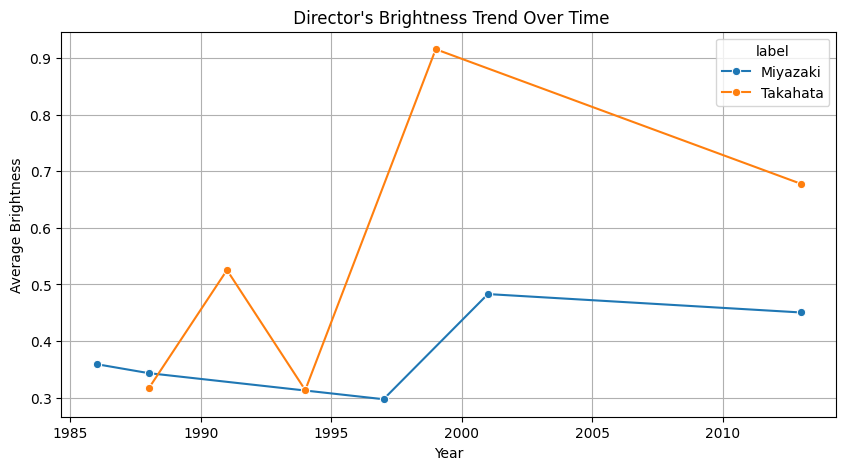

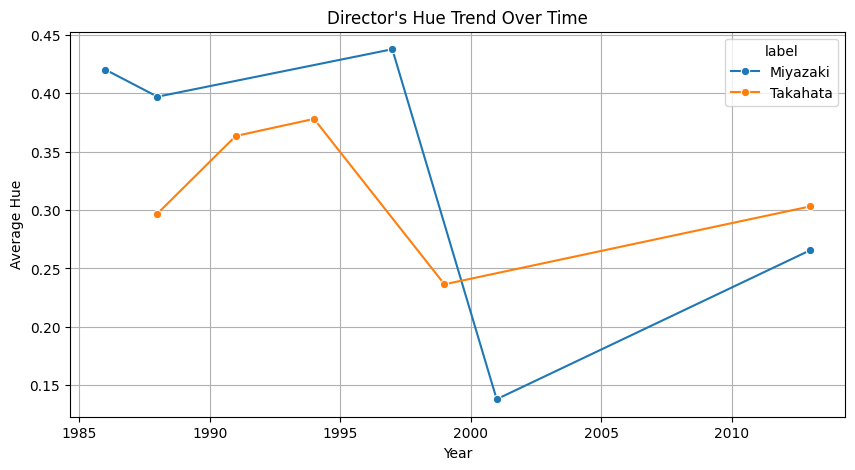

In [ ]:
#Plot the brightness and hue trends of the director's works over time
#We already saved the hue and brightness of each movie into dataframe, use charts to visualize these values

#Use the director to distinguish colors to plot brightness trends, shows how the brightness of two directors' films changes over time
plt.figure(figsize=(10, 5))
sns.lineplot(data=movie_stats, x='year', y='brightness', hue='label', marker='o')
plt.title(" Director's Brightness Trend Over Time")
plt.xlabel("Year")
plt.ylabel("Average Brightness")
plt.grid(True)
plt.savefig("/content/drive/MyDrive/Colab Notebooks/dh project/brightness_trend.png")
plt.show()

#Show the changing trends of hue in two directors' films
plt.figure(figsize=(10, 5))
sns.lineplot(data=movie_stats, x='year', y='hue', hue='label', marker='o')
plt.title("Director's Hue Trend Over Time")
plt.xlabel("Year")
plt.ylabel("Average Hue")
plt.grid(True)
plt.savefig("/content/drive/MyDrive/Colab Notebooks/dh project/hue_trend.png")
plt.show()


In [ ]:
"""
Next, devide the data into training set, verification set and test set.
Due to the small data sample size, I will apply data enhancement to improve the model generalization ability.
Now divide all the screenshots of the two directors into training, verification and testing sets in a ratio of 8:1:1
"""
#Define a function to split the original dataset, and set the random seed to ensure that the results of each split are consistent and reproducible
def split_dataset(input_dir, output_dir, split_ratio=(0.8, 0.1, 0.1), seed=42):
    random.seed(seed)
    #Traverse the two director folders in the original directory (Miyazaki, Takahata)
    for label in os.listdir(input_dir):
        label_path = os.path.join(input_dir, label)
        if not os.path.isdir(label_path):
            continue

        #Collects all image paths of each director
        all_images = []
        for root, _, files in os.walk(label_path):
            for f in files:
                if f.lower().endswith(('.jpg', '.png')):
                    all_images.append(os.path.join(root, f))

        #Shuffle the order and calculate the number of three categories based on the total number of images
        random.shuffle(all_images)
        n_total = len(all_images)
        n_train = int(n_total * split_ratio[0])
        n_val = int(n_total * split_ratio[1])
        n_test = n_total - n_train - n_val

        split_sets = {
            'train': all_images[:n_train],
            'val': all_images[n_train:n_train + n_val],
            'test': all_images[n_train + n_val:]
        }

        #Copy the divided data and save it to the specified folder for later use
        for split_name, images in split_sets.items():
            target_dir = os.path.join(output_dir, split_name, label)
            os.makedirs(target_dir, exist_ok=True)
            #Copy each image from the original path to the destination path
            for src_path in images:
                shutil.copy2(src_path, target_dir)

        print(f"{label}: There are {n_total} images, split into --- Train: {n_train}, Val: {n_val}, Test: {n_test}")

#Define the input and output file to split the dataset
input_dir = "/content/drive/MyDrive/Colab Notebooks/dh project/original_data"
output_dir = "/content/drive/MyDrive/Colab Notebooks/dh project/dataset"
split_dataset(input_dir, output_dir)


miyazaki: There are 250 images, split into --- Train: 200, Val: 25, Test: 25
takahata: There are 250 images, split into --- Train: 200, Val: 25, Test: 25


In [ ]:
#Since I have a small amount of data, I added data enhancement to make the training set richer。
train_datagen = ImageDataGenerator(
    #Normalize pixel values to [0, 1]
    rescale=1./255,
    #Rotate randomly within 20 degrees
    rotation_range=20,
    #Horizontal translation
    width_shift_range=0.1,
    #Vertical translation
    height_shift_range=0.1,
    #Adjust the brightness
    brightness_range=[0.8, 1.2],
    #Mistangent transformation
    shear_range=0.2,
    #Random scaling
    zoom_range=0.2,
    #Horizontal flip
    horizontal_flip=True,
    #Border fill method
    fill_mode='nearest'
)

#Validation and test sets are not enhanced, only normalized
val_test_datagen = ImageDataGenerator(rescale=1./255)

#Validate the paths of the training set, validation set, and test set
train_dir = "/content/drive/MyDrive/Colab Notebooks/dh project/dataset/train"
val_dir   = "/content/drive/MyDrive/Colab Notebooks/dh project/dataset/val"
test_dir  = "/content/drive/MyDrive/Colab Notebooks/dh project/dataset/test"

#Load the data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    #Because I will use VGG16 method later, so set the image size of the input model to the size required by VGG16, 224x224.
    target_size=(224, 224),
    batch_size=32,
    #It's a binary task（Miyazaki vs Takahata）
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    #Set shuffle=False to accurately evaluate classification results in the future
    shuffle=False
)


Found 400 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


Image batch shape: (32, 224, 224, 3)
Label batch shape: (32,)
First 10 labels: [0. 0. 1. 1. 1. 0. 0. 0. 0. 1.]


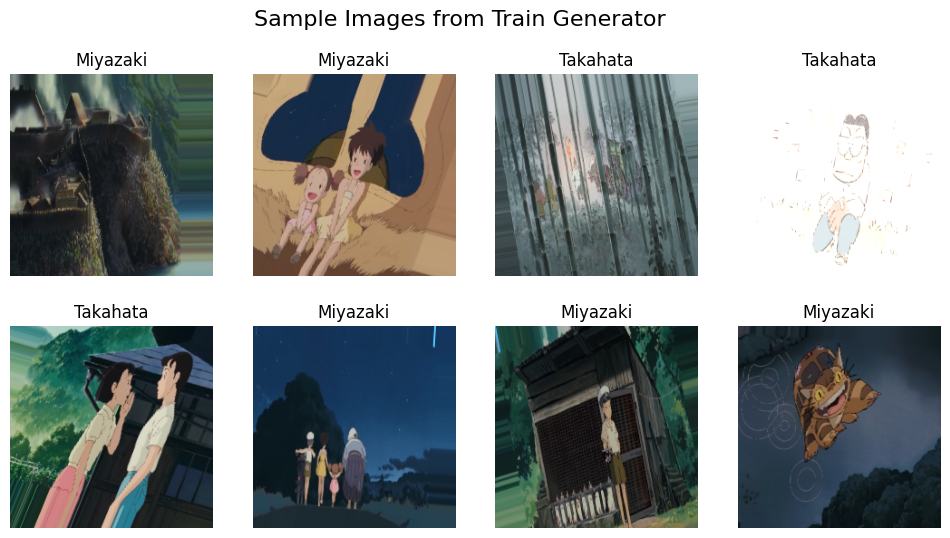

In [ ]:
#Now I will test the data pipeline, checking the size of the data and the labels
#Get one batch from train_generator(Already set the batch_size=32 before）
images, labels = next(train_generator)

#Print the shape of them to check
#Should be (32, 224, 224, 3)
print("Image batch shape:", images.shape)
#Should be (32,)
print("Label batch shape:", labels.shape)
#Should be binary(0/1)
print("First 10 labels:", labels[:10])

#Visualize the first 8 picture of the batch
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(images[i])
    label_name = "Miyazaki" if labels[i] == 0 else "Takahata"
    plt.title(label_name)
    plt.axis('off')
plt.suptitle("Sample Images from Train Generator", fontsize=16)
plt.show()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,846,273 (56.63 MB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.4903 - loss: 0.7688 
Epoch 1: val_accuracy improved from -inf to 0.54000, saving model to director_style_model.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 349s 27s/step - accuracy: 0.4898 - loss: 0.7672 - val_accuracy: 0.5400 - val_loss: 0.6853 - learning_rate: 1.0000e-04
Epoch 2/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.5206 - loss: 0.6810 
Epoch 2: val_accuracy improved from 0.54000 to 0.58000, saving model to director_style_model.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 318s 24s/step - accuracy: 0.5198 - loss: 0.6823 - val_accuracy: 0.5800 - val_loss: 0.6798 - learning_rate: 1.0000e-04
Epoch 3/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.5795 - loss: 0.7030 
Epoch 3: val_accuracy improved from 0.58000 to 0.68000, saving model to director_style_model.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 319s 24s/step - accuracy: 0.5785 - loss: 0.7027 - val_accuracy: 0.6800 - val_loss: 0.6742 - learning_rate: 1.0000e-04
Epoch 4/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.6260 - loss: 0.6787 
Epoch 4: val_accuracy did not improve from 0.68000
13/13 ━━━━━━━━━━━━━━━━━━━━ 316s 24s/step - accuracy: 0.6243 - loss: 0.6793 - val_accuracy: 0.6000 - val_loss: 0.6689 - learning_rate: 1.0000e-04
Epoch 5/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.5512 - loss: 0.6948 
Epoch 5: val_accuracy did not improve from 0.68000
13/13 ━━━━━━━━━━━━━━━━━━━━ 310s 24s/step - accuracy: 0.5534 - loss: 0.6929 - val_accuracy: 0.6800 - val_loss: 0.6638 - learning_rate: 1.0000e-04
Epoch 6/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.5693 - loss: 0.6986 
Epoch 6: val_accuracy did not improve from 0.68000
13/13 ━━━━━━━━━━━━━━━━━━━━ 325s 25s/step - accuracy: 0.5692 - loss: 0.6980 - val_accuracy: 0.6400 - val_loss: 0.6596 - learning_rate: 1.0000e-04
Epoch 7/15
1

13/13 ━━━━━━━━━━━━━━━━━━━━ 325s 24s/step - accuracy: 0.6580 - loss: 0.6409 - val_accuracy: 0.7000 - val_loss: 0.6532 - learning_rate: 1.0000e-04
Epoch 9/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.6048 - loss: 0.6570 
Epoch 9: val_accuracy did not improve from 0.70000
13/13 ━━━━━━━━━━━━━━━━━━━━ 313s 24s/step - accuracy: 0.6031 - loss: 0.6581 - val_accuracy: 0.6400 - val_loss: 0.6486 - learning_rate: 1.0000e-04
Epoch 10/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.6238 - loss: 0.6407 
Epoch 10: val_accuracy did not improve from 0.70000
13/13 ━━━━━━━━━━━━━━━━━━━━ 320s 25s/step - accuracy: 0.6241 - loss: 0.6408 - val_accuracy: 0.6400 - val_loss: 0.6452 - learning_rate: 1.0000e-04
Epoch 11/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.6660 - loss: 0.6390 
Epoch 11: val_accuracy did not improve from 0.70000
13/13 ━━━━━━━━━━━━━━━━━━━━ 312s 24s/step - accuracy: 0.6670 - loss: 0.6378 - val_accuracy: 0.6400 - val_loss: 0.6423 - learning_rate: 1.0000e-04
Epoch 12

Test set Loss: 0.6134857535362244
Test set Accuracy: 0.699999988079071


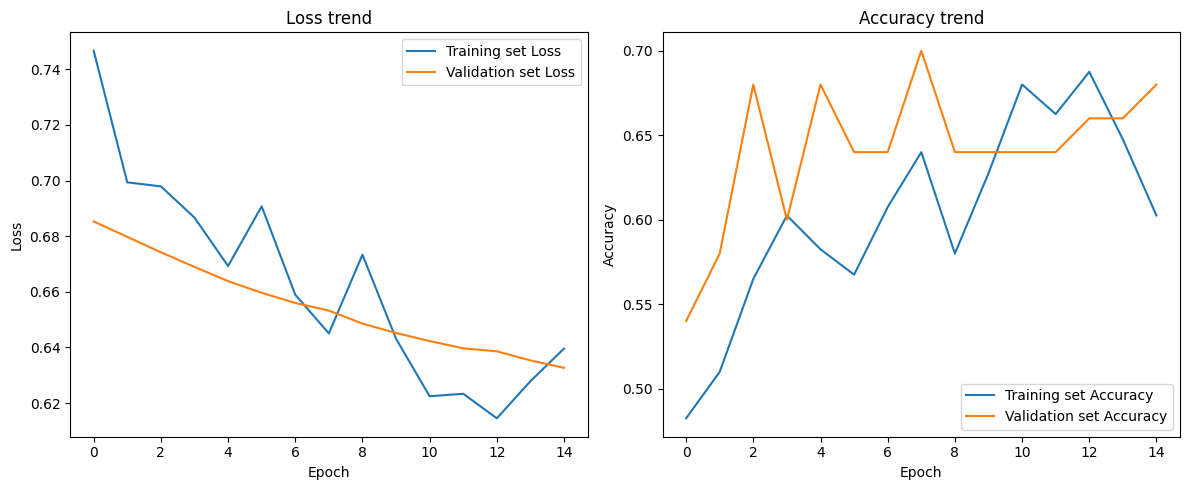

In [ ]:
"""
Now I will build the model, based on the results of the previous run
I decided to use VGG to pre-train the model and freeze the convolutional layer to build the new model
"""
#Load the VGG16 pre-trained model, excluding the top-level fully connected part, and set the input size to 224x224x3
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
#Freeze the convolution base and set it not to update its weight during initial training
base_model.trainable = False

#Build a new model
model = Sequential([
    base_model,
    #Global averaging pooling layer: turns the convolutional output into a one-dimensional vector,
    #turns the feature graph of [7,7,512] directly into [1, 512], and reduces parameters
    GlobalAveragePooling2D(),
    #Add a full connection layer with the number of nodes temporarily set to a modest size of 256
    Dense(256, activation='relu'),
    #Use dropout to prevent overfitting
    Dropout(0.5),
    #Output layer: because it is a binary classification task, use a single node and sigmoid activation function
    Dense(1, activation='sigmoid')
])

#Print the summary of the model to check if it's correct
model.summary()

#Model compilation
#Use the Adam optimizer and set a smaller learning rate to make the model more stable
optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

#Set the callback function, first save the model that performs best in the validation set as a.h5 file
checkpoint_cb = ModelCheckpoint("director_style_model.h5", monitor='val_accuracy',
                                save_best_only=True, verbose=1)
#If val_loss is verified for 5 consecutive rounds without improvement, stop training early to avoid wasting time
early_stop_cb = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
#If val_loss does not improve within three rounds, the learning rate is reduced by a factor of 10 to help the model jump out of the stuck area.
reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

#Train the model
#I already set the train_generator and val_generator in previous code, now pass in the enhanced training
history = model.fit(
    train_generator,
    #Train 15 epochs and evaluate performance with validation sets
    epochs=15,
    validation_data=val_generator,
    #Set the callback functions I just defined (autosave, early stop, adjust learning rate)
    callbacks=[checkpoint_cb, early_stop_cb, reduce_lr_cb]
)

#Evaluate the model after training
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test set Loss:", test_loss)
print("Test set Accuracy:", test_accuracy)

#Save the entire model structure and parameters
model.save("final_director_style_model.h5")



#Plot the loss and accuracy curve during training
plt.figure(figsize=(12, 5))

#Plot the loss curve
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training set Loss')
plt.plot(history.history['val_loss'], label='Validation set Loss')
plt.title('Loss trend')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

#Plot the accuracy curve
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training set Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation set Accuracy')
plt.title('Accuracy trend')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

#Use plt.tight_layout() to automatically adjust the spacing between subplots
plt.tight_layout()
plt.show()

Fine-tuning: Unfreezing the last 4 layers of VGG16.
Starting fine-tuning training from epoch 15 to 30
Epoch 16/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25s/step - accuracy: 0.6434 - loss: 0.6051 
Epoch 16: val_accuracy improved from -inf to 0.62000, saving model to director_style_model_ft.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 371s 28s/step - accuracy: 0.6444 - loss: 0.6053 - val_accuracy: 0.6200 - val_loss: 0.6142 - learning_rate: 1.0000e-05
Epoch 17/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26s/step - accuracy: 0.6599 - loss: 0.6006 
Epoch 17: val_accuracy improved from 0.62000 to 0.72000, saving model to director_style_model_ft.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 374s 29s/step - accuracy: 0.6624 - loss: 0.5989 - val_accuracy: 0.7200 - val_loss: 0.5852 - learning_rate: 1.0000e-05
Epoch 18/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25s/step - accuracy: 0.6576 - loss: 0.5818 
Epoch 18: val_accuracy did not improve from 0.72000
13/13 ━━━━━━━━━━━━━━━━━━━━ 368s 28s/step - accuracy: 0.6603 - loss: 0.5794 - val_accuracy: 0.7000 - val_loss: 0.5641 - learning_rate: 1.0000e-05
Epoch 19/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25s/step - accuracy: 0.7430 - loss: 0.5384 
Epoch 19: val_accuracy did not improve from 0.72000
13/13 ━━━━━━━━━━━━━━━━━━━━ 362s 28s/step - accuracy: 0.7419 - loss: 0.5391 - val_accuracy: 0.7000 - val_loss: 0.5521 - learning_rate: 1.0000e-05
Epoch 20/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25s/step - accuracy: 0.7454 - loss: 0.5086 
Epoch 20: val_accuracy did not improve from 0.72000
13/13 ━━━━━━━━━━━━━━━━━━━━ 366s 28s/step - accuracy: 0.7461 - loss: 0.5091 - val_accuracy: 0.6400 - val_loss: 0.5626 - learning_rate: 1.0000e-05
Epoch 

13/13 ━━━━━━━━━━━━━━━━━━━━ 376s 28s/step - accuracy: 0.7201 - loss: 0.5207 - val_accuracy: 0.7400 - val_loss: 0.5157 - learning_rate: 1.0000e-05
Epoch 22/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25s/step - accuracy: 0.7529 - loss: 0.4667 
Epoch 22: val_accuracy did not improve from 0.74000
13/13 ━━━━━━━━━━━━━━━━━━━━ 367s 28s/step - accuracy: 0.7520 - loss: 0.4683 - val_accuracy: 0.6600 - val_loss: 0.5678 - learning_rate: 1.0000e-05
Epoch 23/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25s/step - accuracy: 0.7695 - loss: 0.4845 
Epoch 23: val_accuracy did not improve from 0.74000
13/13 ━━━━━━━━━━━━━━━━━━━━ 364s 28s/step - accuracy: 0.7694 - loss: 0.4844 - val_accuracy: 0.7200 - val_loss: 0.5059 - learning_rate: 1.0000e-05
Epoch 24/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26s/step - accuracy: 0.8395 - loss: 0.4359 
Epoch 24: val_accuracy did not improve from 0.74000
13/13 ━━━━━━━━━━━━━━━━━━━━ 387s 29s/step - accuracy: 0.8365 - loss: 0.4380 - val_accuracy: 0.7000 - val_loss: 0.5127 - learning_rate: 1.0000e-05
Epoch 

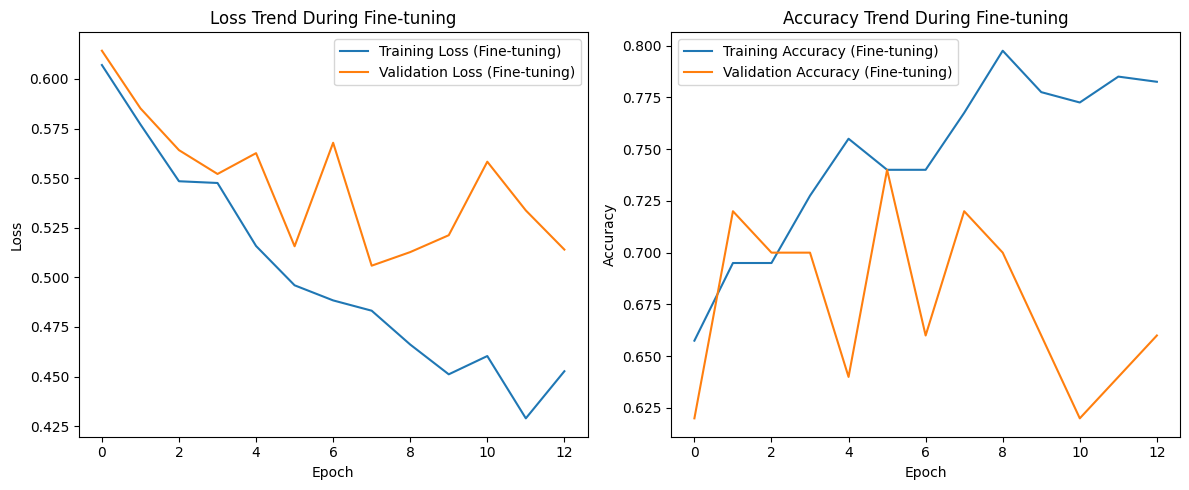

In [ ]:
"""
The accuracy of the model is about 69.9% now, so I need to justify the parameters of the model to improve the accuracy.
First, defrost the last 4 layers in the VGG16 model.
Second, adjust the learning rate of Adam optimizer to 1e-5 to check if the accuracy is improve.
"""

#Fine-tuning: thawing the last 4 convolution layers and continue training
#First, set the entire base_model to trainable
base_model.trainable = True
#Freeze the front part of VGG16 and thaw only the last 4 layers
for layer in base_model.layers[:-4]:
    layer.trainable = False
print("Fine-tuning: Unfreezing the last 4 layers of VGG16.")

#Recompile the model with a lower learning rate "1e-5"
optimizer = Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

#Redefine the callback function
checkpoint_cb = ModelCheckpoint("director_style_model_ft.h5", monitor='val_accuracy',
                                  save_best_only=True, verbose=1)
early_stop_cb = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

#Continue training the model, I already ran 15 epochs before
fine_tune_epochs = 15
#The fine-tuned epoch follows the previous one, counting from 16
initial_epoch = history.epoch[-1] + 1 if history is not None else 0
total_epochs = initial_epoch + fine_tune_epochs

print(f"Starting fine-tuning training from epoch {initial_epoch} to {total_epochs}")

history_ft = model.fit(
    train_generator,
    epochs=total_epochs,
    #Follow up training after the last training
    initial_epoch=initial_epoch,
    validation_data=val_generator,
    callbacks=[checkpoint_cb, early_stop_cb, reduce_lr_cb]
)

#After fine-tuning the training, reevaluat the model on the test set
test_loss_ft, test_accuracy_ft = model.evaluate(test_generator)
print("Fine-tuned Test set Loss:", test_loss_ft)
print("Fine-tuned Test set Accuracy:", test_accuracy_ft)


#Plot losses and accuracy changes during fine-tuning training as before(loss curve and accuracy curve)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_ft.history['loss'], label='Training Loss (Fine-tuning)')
plt.plot(history_ft.history['val_loss'], label='Validation Loss (Fine-tuning)')
plt.title('Loss Trend During Fine-tuning')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_ft.history['accuracy'], label='Training Accuracy (Fine-tuning)')
plt.plot(history_ft.history['val_accuracy'], label='Validation Accuracy (Fine-tuning)')
plt.title('Accuracy Trend During Fine-tuning')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

#Use plt.tight_layout() to automatically adjust the spacing between subplots
plt.tight_layout()
plt.show()

Further fine-tuning: Unfreezing the last 6 layers of VGG16.
Starting further fine-tuning from epoch 28 to 48...
Epoch 29/48
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29s/step - accuracy: 0.6930 - loss: 0.5392 
Epoch 29: val_accuracy improved from -inf to 0.70000, saving model to director_style_model_ft_best.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 418s 32s/step - accuracy: 0.6938 - loss: 0.5378 - val_accuracy: 0.7000 - val_loss: 0.5090 - learning_rate: 1.0000e-05
Epoch 30/48
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30s/step - accuracy: 0.7881 - loss: 0.4434 
Epoch 30: val_accuracy did not improve from 0.70000
13/13 ━━━━━━━━━━━━━━━━━━━━ 411s 33s/step - accuracy: 0.7888 - loss: 0.4431 - val_accuracy: 0.6400 - val_loss: 0.5893 - learning_rate: 1.0000e-05
Epoch 31/48
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28s/step - accuracy: 0.7557 - loss: 0.4976 
Epoch 31: val_accuracy did not improve from 0.70000
13/13 ━━━━━━━━━━━━━━━━━━━━ 407s 31s/step - accuracy: 0.7569 - loss: 0.4955 - val_accuracy: 0.7000 - val_loss: 0.4984 - learning_rate: 1.0000e-05
Epoch 32/48
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28s/step - accuracy: 0.8100 - loss: 0.4566 
Epoch 32: val_accuracy did not improve from 0.70000
13/13 ━━━━━━━━━━━━━━━━━━━━ 405s 31s/step - accuracy: 0.8098 - loss: 0.4560 - val_accuracy: 0.6800 - val_loss: 0.4835 - learning_rate: 1.0000e-05
Epoch 

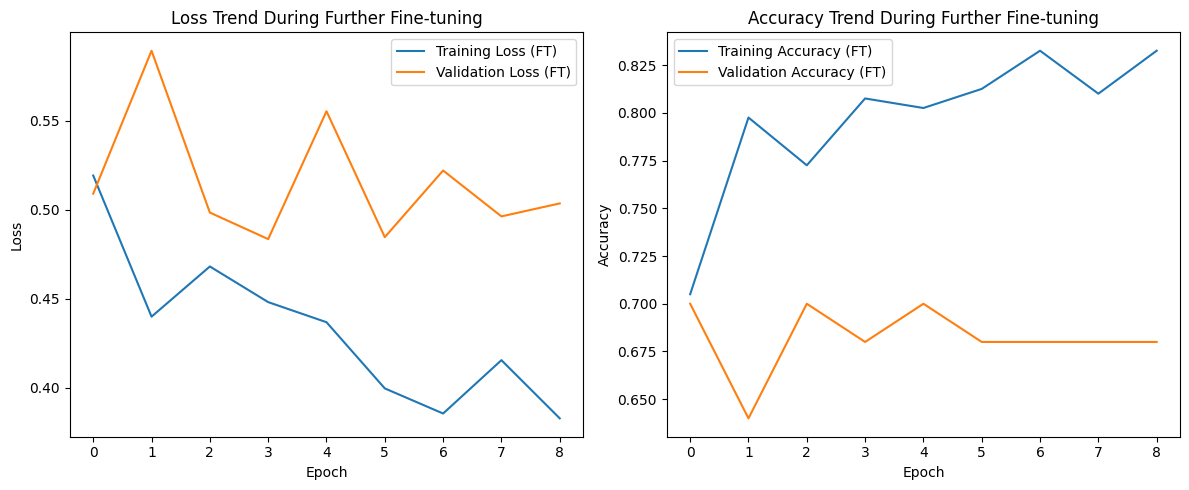

In [ ]:
"""
(The second fine-tuning)
Further model fine-tuning 2：
This time I defrost the last six layers, and extend the training rounds
"""

#Same as before but with 6 layers of freezing
base_model.trainable = True

for layer in base_model.layers[:-6]:
    layer.trainable = False
for layer in base_model.layers[-6:]:
    layer.trainable = True
print("Further fine-tuning: Unfreezing the last 6 layers of VGG16.")

#Recompile the model and set the same learning rate as the previous training to maintain training stability
optimizer = Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

#Define the callback function as before
checkpoint_cb = ModelCheckpoint("director_style_model_ft_best.h5", monitor='val_accuracy',
                                  save_best_only=True, verbose=1)
early_stop_cb = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

#This time set 20 epoches
fine_tune_epochs = 20
#Continue the training on the basis of the previous training, which stopped at the 27th epoch due to the early stop setting
initial_epoch = history_ft.epoch[-1] + 1 if 'history_ft' in globals() else 0
total_epochs = initial_epoch + fine_tune_epochs

print(f"Starting further fine-tuning from epoch {initial_epoch} to {total_epochs}...")

#Train the model
history_ft2 = model.fit(
    train_generator,
    epochs=total_epochs,
    initial_epoch=initial_epoch,
    validation_data=val_generator,
    callbacks=[checkpoint_cb, early_stop_cb, reduce_lr_cb]
)

#Evaluate the 2nd further fine-tuned model on the test set
test_loss_ft2, test_accuracy_ft2 = model.evaluate(test_generator)
print("Further Fine-tuned Test set Loss:", test_loss_ft2)
print("Further Fine-tuned Test set Accuracy:", test_accuracy_ft2)

#Plot the trend of Loss and Accuracy during further fine-tuning as before
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_ft2.history['loss'], label='Training Loss (FT)')
plt.plot(history_ft2.history['val_loss'], label='Validation Loss (FT)')
plt.title('Loss Trend During Further Fine-tuning')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_ft2.history['accuracy'], label='Training Accuracy (FT)')
plt.plot(history_ft2.history['val_accuracy'], label='Validation Accuracy (FT)')
plt.title('Accuracy Trend During Further Fine-tuning')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,846,273 (56.63 MB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28s/step - accuracy: 0.5186 - loss: 0.7203 
Epoch 1: val_accuracy improved from -inf to 0.48000, saving model to /content/drive/MyDrive/Colab Notebooks/dh project/director_style_model_init.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 477s 36s/step - accuracy: 0.5169 - loss: 0.7217 - val_accuracy: 0.4800 - val_loss: 0.6983 - learning_rate: 1.0000e-04
Epoch 2/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.5170 - loss: 0.7453 
Epoch 2: val_accuracy did not improve from 0.48000
13/13 ━━━━━━━━━━━━━━━━━━━━ 275s 21s/step - accuracy: 0.5177 - loss: 0.7445 - val_accuracy: 0.4600 - val_loss: 0.6923 - learning_rate: 1.0000e-04
Epoch 3/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.5285 - loss: 0.7261 
Epoch 3: val_accuracy improved from 0.48000 to 0.52000, saving model to /content/drive/MyDrive/Colab Notebooks/dh project/director_style_model_init.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 287s 22s/step - accuracy: 0.5294 - loss: 0.7249 - val_accuracy: 0.5200 - val_loss: 0.6871 - learning_rate: 1.0000e-04
Epoch 4/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.4905 - loss: 0.7526 
Epoch 4: val_accuracy improved from 0.52000 to 0.58000, saving model to /content/drive/MyDrive/Colab Notebooks/dh project/director_style_model_init.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 280s 21s/step - accuracy: 0.4924 - loss: 0.7505 - val_accuracy: 0.5800 - val_loss: 0.6832 - learning_rate: 1.0000e-04
Epoch 5/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.5313 - loss: 0.7213 
Epoch 5: val_accuracy improved from 0.58000 to 0.60000, saving model to /content/drive/MyDrive/Colab Notebooks/dh project/director_style_model_init.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 286s 22s/step - accuracy: 0.5323 - loss: 0.7206 - val_accuracy: 0.6000 - val_loss: 0.6785 - learning_rate: 1.0000e-04
Epoch 6/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.5826 - loss: 0.6902 
Epoch 6: val_accuracy did not improve from 0.60000
13/13 ━━━━━━━━━━━━━━━━━━━━ 323s 22s/step - accuracy: 0.5822 - loss: 0.6891 - val_accuracy: 0.5600 - val_loss: 0.6733 - learning_rate: 1.0000e-04
Epoch 7/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.5959 - loss: 0.6721 
Epoch 7: val_accuracy did not improve from 0.60000
13/13 ━━━━━━━━━━━━━━━━━━━━ 286s 22s/step - accuracy: 0.5942 - loss: 0.6722 - val_accuracy: 0.5800 - val_loss: 0.6700 - learning_rate: 1.0000e-04
Epoch 8/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.6006 - loss: 0.6624 
Epoch 8: val_accuracy did not improve from 0.60000
13/13 ━━━━━━━━━━━━━━━━━━━━ 314s 21s/step - accuracy: 0.6007 - loss: 0.6628 - val_accuracy: 0.5600 - val_loss: 0.6670 - learning_rate: 1.0000e-04
Epoch 9/15
1

13/13 ━━━━━━━━━━━━━━━━━━━━ 280s 21s/step - accuracy: 0.6103 - loss: 0.6690 - val_accuracy: 0.6400 - val_loss: 0.6531 - learning_rate: 1.0000e-04
Epoch 14/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.6247 - loss: 0.6443 
Epoch 14: val_accuracy did not improve from 0.64000
13/13 ━━━━━━━━━━━━━━━━━━━━ 328s 22s/step - accuracy: 0.6236 - loss: 0.6439 - val_accuracy: 0.6400 - val_loss: 0.6514 - learning_rate: 1.0000e-04
Epoch 15/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.6412 - loss: 0.6364 
Epoch 15: val_accuracy did not improve from 0.64000
13/13 ━━━━━━━━━━━━━━━━━━━━ 280s 21s/step - accuracy: 0.6431 - loss: 0.6354 - val_accuracy: 0.6000 - val_loss: 0.6468 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 15.
2/2 ━━━━━━━━━━━━━━━━━━━━ 38s 11s/step - accuracy: 0.6958 - loss: 0.6192


Test set Loss: 0.6089340448379517
Test set Accuracy: 0.699999988079071


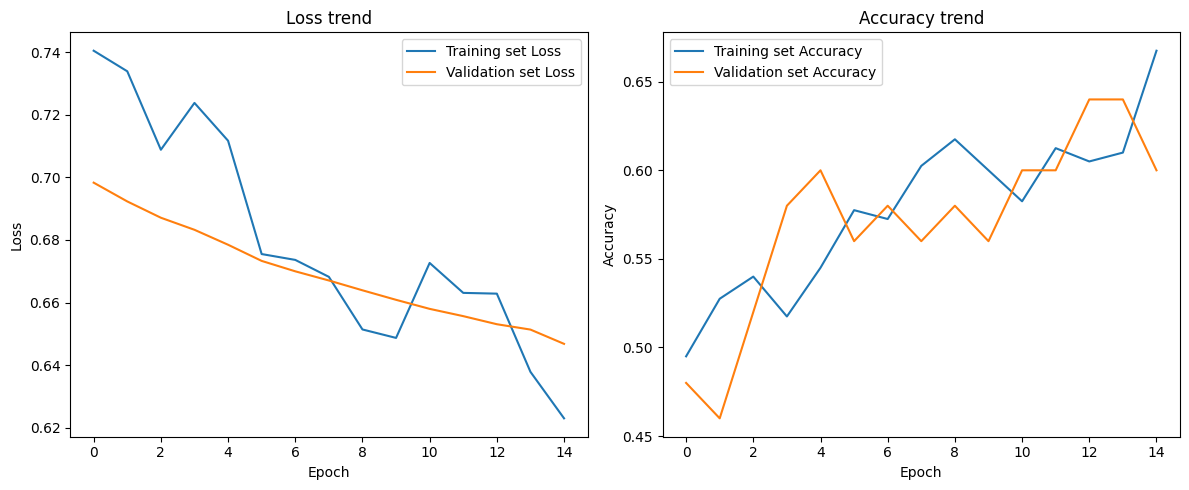

In [ ]:
"""
After the previous model construction and the model after two parameter adjustments, it can be seen that unfreezing more convolutional layers will cause serious overfitting problems.
Now I re-build the model without regularization and the model with regularization,
set random seeds and save the model to Google drive for future use。
Rerun the code of the original model and the first fine-tuning model, and save the final model I choose
"""

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

#Load the VGG16 pre-trained model, excluding the top-level fully connected part, and set the input size to 224x224x3
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
#Freeze the convolution base and set it not to update its weight during initial training
base_model.trainable = False

#Build a new model
model = Sequential([
    base_model,
    #Global averaging pooling layer: turns the convolutional output into a one-dimensional vector,
    #turns the feature graph of [7,7,512] directly into [1, 512], and reduces parameters
    GlobalAveragePooling2D(),
    #Add a full connection layer with the number of nodes temporarily set to a modest size of 256
    Dense(256, activation='relu'),
    #Use dropout to prevent overfitting
    Dropout(0.5),
    #Output layer: because it is a binary classification task, use a single node and sigmoid activation function
    Dense(1, activation='sigmoid')
])

#Print the summary of the model to check if it's correct
model.summary()

#Model compilation
#Use the Adam optimizer and set a smaller learning rate to make the model more stable
optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

#Set the callback function, first save the model that performs best in the validation set as a.h5 file
checkpoint_cb = ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/dh project/director_style_model_init.h5", monitor='val_accuracy',
                                save_best_only=True, verbose=1)
#If val_loss is verified for 5 consecutive rounds without improvement, stop training early to avoid wasting time
early_stop_cb = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
#If val_loss does not improve within three rounds, the learning rate is reduced by a factor of 10 to help the model jump out of the stuck area.
reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

#Train the model
#I already set the train_generator and val_generator in previous code, now pass in the enhanced training
history = model.fit(
    train_generator,
    #Train 15 epochs and evaluate performance with validation sets
    epochs=15,
    validation_data=val_generator,
    #Set the callback functions I just defined (autosave, early stop, adjust learning rate)
    callbacks=[checkpoint_cb, early_stop_cb, reduce_lr_cb]
)

#Evaluate the model after training
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test set Loss:", test_loss)
print("Test set Accuracy:", test_accuracy)

#Save the entire model structure and parameters
model.save("final_director_style_model.h5")


#Plot the loss and accuracy curve during training
plt.figure(figsize=(12, 5))

#Plot the loss curve
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training set Loss')
plt.plot(history.history['val_loss'], label='Validation set Loss')
plt.title('Loss trend')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

#Plot the accuracy curve
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training set Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation set Accuracy')
plt.title('Accuracy trend')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

#Use plt.tight_layout() to automatically adjust the spacing between subplots
plt.tight_layout()
plt.show()

Fine-tuning: Unfreezing the last 4 layers of VGG16.
Starting fine-tuning training from epoch 15 to 30
Epoch 16/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.6705 - loss: 0.6253 
Epoch 16: val_accuracy improved from -inf to 0.58000, saving model to /content/drive/MyDrive/Colab Notebooks/dh project/director_style_model_ft1.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 336s 25s/step - accuracy: 0.6703 - loss: 0.6246 - val_accuracy: 0.5800 - val_loss: 0.6267 - learning_rate: 1.0000e-05
Epoch 17/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.6588 - loss: 0.5911 
Epoch 17: val_accuracy improved from 0.58000 to 0.76000, saving model to /content/drive/MyDrive/Colab Notebooks/dh project/director_style_model_ft1.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 337s 26s/step - accuracy: 0.6608 - loss: 0.5904 - val_accuracy: 0.7600 - val_loss: 0.5893 - learning_rate: 1.0000e-05
Epoch 18/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.7299 - loss: 0.5695 
Epoch 18: val_accuracy did not improve from 0.76000
13/13 ━━━━━━━━━━━━━━━━━━━━ 328s 25s/step - accuracy: 0.7288 - loss: 0.5693 - val_accuracy: 0.6400 - val_loss: 0.5841 - learning_rate: 1.0000e-05
Epoch 19/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24s/step - accuracy: 0.7166 - loss: 0.5428 
Epoch 19: val_accuracy did not improve from 0.76000
13/13 ━━━━━━━━━━━━━━━━━━━━ 340s 26s/step - accuracy: 0.7161 - loss: 0.5438 - val_accuracy: 0.7200 - val_loss: 0.5663 - learning_rate: 1.0000e-05
Epoch 20/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.7413 - loss: 0.4957 
Epoch 20: val_accuracy did not improve from 0.76000
13/13 ━━━━━━━━━━━━━━━━━━━━ 326s 25s/step - accuracy: 0.7393 - loss: 0.4972 - val_accuracy: 0.6800 - val_loss: 0.5337 - learning_rate: 1.0000e-05
Epoch 

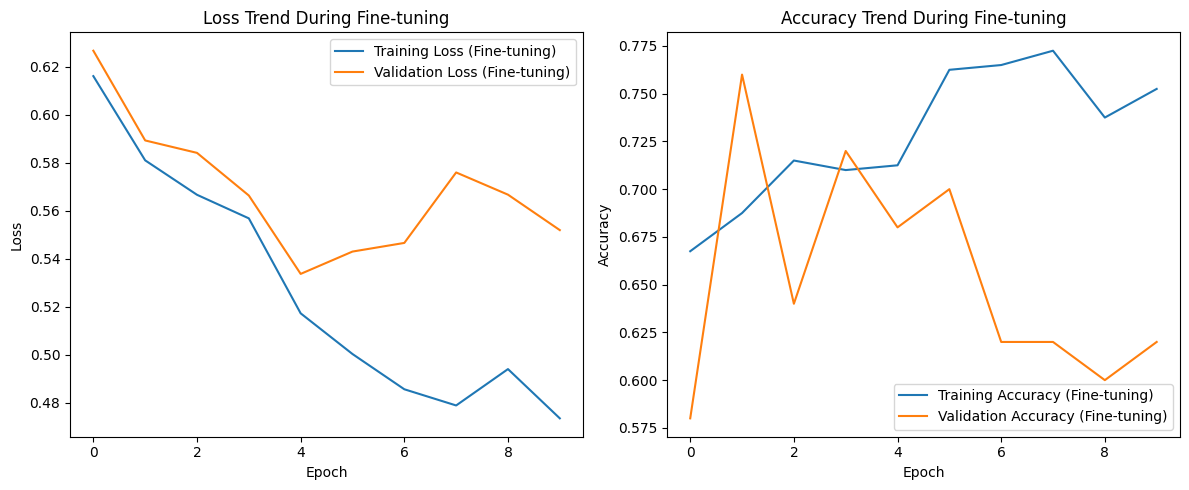

In [ ]:
"""
Rerun the code of the first fine-tuning after the original model, and save it into google drive
"""

base_model.trainable = True
#Freeze the front part of VGG16 and thaw only the last 4 layers
for layer in base_model.layers[:-4]:
    layer.trainable = False
print("Fine-tuning: Unfreezing the last 4 layers of VGG16.")

#Recompile the model with a lower learning rate "1e-5"
optimizer = Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

#Redefine the callback function
checkpoint_cb = ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/dh project/director_style_model_ft1.h5", monitor='val_accuracy',
                                  save_best_only=True, verbose=1)
early_stop_cb = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

#Continue training the model, I already ran 15 epochs before
fine_tune_epochs = 15
#The fine-tuned epoch follows the previous one, counting from 16
initial_epoch = history.epoch[-1] + 1 if history is not None else 0
total_epochs = initial_epoch + fine_tune_epochs

print(f"Starting fine-tuning training from epoch {initial_epoch} to {total_epochs}")

history_ft = model.fit(
    train_generator,
    epochs=total_epochs,
    #Follow up training after the last training
    initial_epoch=initial_epoch,
    validation_data=val_generator,
    callbacks=[checkpoint_cb, early_stop_cb, reduce_lr_cb]
)

#After fine-tuning the training, reevaluat the model on the test set
test_loss_ft, test_accuracy_ft = model.evaluate(test_generator)
print("Fine-tuned Test set Loss:", test_loss_ft)
print("Fine-tuned Test set Accuracy:", test_accuracy_ft)


#Plot losses and accuracy changes during fine-tuning training as before(loss curve and accuracy curve)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_ft.history['loss'], label='Training Loss (Fine-tuning)')
plt.plot(history_ft.history['val_loss'], label='Validation Loss (Fine-tuning)')
plt.title('Loss Trend During Fine-tuning')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_ft.history['accuracy'], label='Training Accuracy (Fine-tuning)')
plt.plot(history_ft.history['val_accuracy'], label='Validation Accuracy (Fine-tuning)')
plt.title('Accuracy Trend During Fine-tuning')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

#Use plt.tight_layout() to automatically adjust the spacing between subplots
plt.tight_layout()
plt.show()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,846,273 (56.63 MB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

===== Start Initial Training (Frozen VGG + L2) =====


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.5171 - loss: 0.7544 
Epoch 1: val_accuracy improved from -inf to 0.48000, saving model to /content/drive/MyDrive/Colab Notebooks/dh project/director_style_model_l2.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 305s 23s/step - accuracy: 0.5153 - loss: 0.7558 - val_accuracy: 0.4800 - val_loss: 0.7320 - learning_rate: 1.0000e-04
Epoch 2/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.5170 - loss: 0.7788 
Epoch 2: val_accuracy did not improve from 0.48000
13/13 ━━━━━━━━━━━━━━━━━━━━ 280s 21s/step - accuracy: 0.5177 - loss: 0.7780 - val_accuracy: 0.4600 - val_loss: 0.7254 - learning_rate: 1.0000e-04
Epoch 3/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.5285 - loss: 0.7591 
Epoch 3: val_accuracy improved from 0.48000 to 0.52000, saving model to /content/drive/MyDrive/Colab Notebooks/dh project/director_style_model_l2.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 290s 22s/step - accuracy: 0.5294 - loss: 0.7579 - val_accuracy: 0.5200 - val_loss: 0.7197 - learning_rate: 1.0000e-04
Epoch 4/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.4905 - loss: 0.7850 
Epoch 4: val_accuracy improved from 0.52000 to 0.58000, saving model to /content/drive/MyDrive/Colab Notebooks/dh project/director_style_model_l2.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 301s 21s/step - accuracy: 0.4924 - loss: 0.7829 - val_accuracy: 0.5800 - val_loss: 0.7154 - learning_rate: 1.0000e-04
Epoch 5/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.5313 - loss: 0.7532 
Epoch 5: val_accuracy improved from 0.58000 to 0.60000, saving model to /content/drive/MyDrive/Colab Notebooks/dh project/director_style_model_l2.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 323s 21s/step - accuracy: 0.5323 - loss: 0.7525 - val_accuracy: 0.6000 - val_loss: 0.7100 - learning_rate: 1.0000e-04
Epoch 6/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.5826 - loss: 0.7217 
Epoch 6: val_accuracy did not improve from 0.60000
13/13 ━━━━━━━━━━━━━━━━━━━━ 321s 21s/step - accuracy: 0.5822 - loss: 0.7206 - val_accuracy: 0.5600 - val_loss: 0.7043 - learning_rate: 1.0000e-04
Epoch 7/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.5905 - loss: 0.7031 
Epoch 7: val_accuracy did not improve from 0.60000
13/13 ━━━━━━━━━━━━━━━━━━━━ 275s 21s/step - accuracy: 0.5890 - loss: 0.7032 - val_accuracy: 0.5800 - val_loss: 0.7005 - learning_rate: 1.0000e-04
Epoch 8/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.5974 - loss: 0.6930 
Epoch 8: val_accuracy did not improve from 0.60000
13/13 ━━━━━━━━━━━━━━━━━━━━ 269s 21s/step - accuracy: 0.5974 - loss: 0.6934 - val_accuracy: 0.5600 - val_loss: 0.6971 - learning_rate: 1.0000e-04
Epoch 9/15
1

13/13 ━━━━━━━━━━━━━━━━━━━━ 271s 21s/step - accuracy: 0.6115 - loss: 0.6970 - val_accuracy: 0.6400 - val_loss: 0.6812 - learning_rate: 1.0000e-04
Epoch 14/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.6319 - loss: 0.6723 
Epoch 14: val_accuracy did not improve from 0.64000
13/13 ━━━━━━━━━━━━━━━━━━━━ 328s 21s/step - accuracy: 0.6307 - loss: 0.6718 - val_accuracy: 0.6400 - val_loss: 0.6790 - learning_rate: 1.0000e-04
Epoch 15/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.6372 - loss: 0.6643 
Epoch 15: val_accuracy did not improve from 0.64000
13/13 ━━━━━━━━━━━━━━━━━━━━ 272s 21s/step - accuracy: 0.6394 - loss: 0.6634 - val_accuracy: 0.6000 - val_loss: 0.6743 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 15.
2/2 ━━━━━━━━━━━━━━━━━━━━ 30s 9s/step - accuracy: 0.6958 - loss: 0.6471
Initial Model (with L2) - Test Loss: 0.6365925073623657
Initial Model (with L2) - Test Accuracy: 0.699999988079071


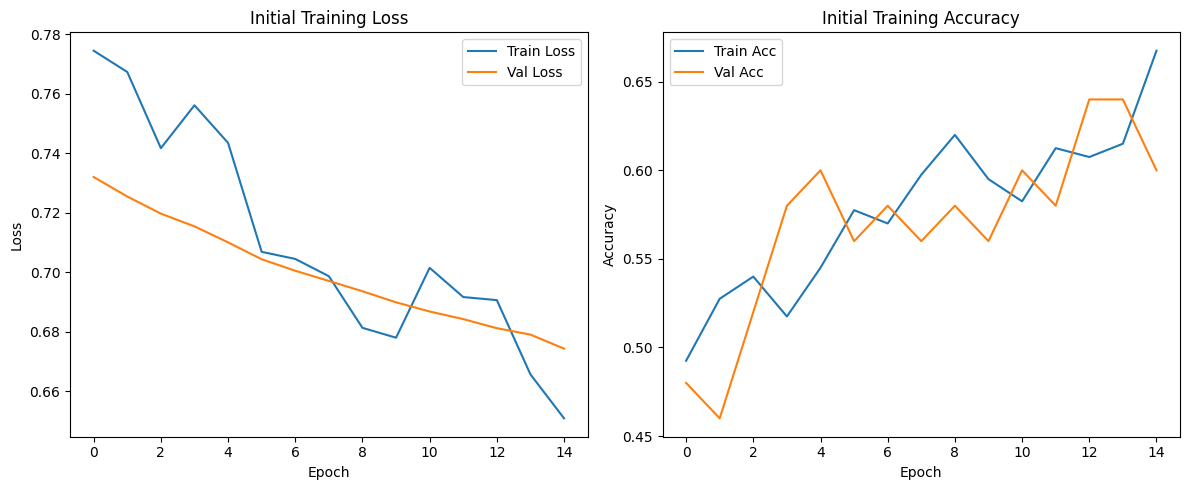

In [ ]:
"""
From the diagram of the above model, there is still an overfitting phenomenon
Now build the model with L2 regularization to reduce overfitting
"""
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

#Building a model with L2 regularization (initial freezing)
#Load the pre-trained VGG16 feature extraction layer and freeze the convolutional layer as before
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False

#Add L2 regularization in Dense layer and adjust learning rate to 1e-4，remain the dropout
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(
        256,
        activation='relu',
        kernel_regularizer=regularizers.l2(1e-4)
    ),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.summary()

#Compilation model and save the model in google drive
optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

checkpoint_cb_init = ModelCheckpoint(
    "/content/drive/MyDrive/Colab Notebooks/dh project/director_style_model_l2.h5",
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)
early_stop_cb_init = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
reduce_lr_cb_init = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

print("===== Start Initial Training (Frozen VGG + L2) =====")
history_init = model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator,
    callbacks=[checkpoint_cb_init, early_stop_cb_init, reduce_lr_cb_init]
)

#Evaluate initial model
test_loss_init, test_acc_init = model.evaluate(test_generator)
print("Initial Model (with L2) - Test Loss:", test_loss_init)
print("Initial Model (with L2) - Test Accuracy:", test_acc_init)

#Visualize the initial training curve
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_init.history['loss'], label='Train Loss')
plt.plot(history_init.history['val_loss'], label='Val Loss')
plt.title('Initial Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_init.history['accuracy'], label='Train Acc')
plt.plot(history_init.history['val_accuracy'], label='Val Acc')
plt.title('Initial Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

Fine-tuning: Unfreezing the last 4 layers of VGG16.
===== Start Fine-Tuning from epoch 16 to 30 (with L2) =====
Epoch 16/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.7950 - loss: 0.5039 
Epoch 16: val_accuracy improved from -inf to 0.56000, saving model to /content/drive/MyDrive/Colab Notebooks/dh project/director_style_model_ft1_l2.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 337s 26s/step - accuracy: 0.7923 - loss: 0.5054 - val_accuracy: 0.5600 - val_loss: 0.6956 - learning_rate: 1.0000e-05
Epoch 17/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.6549 - loss: 0.5965 
Epoch 17: val_accuracy improved from 0.56000 to 0.72000, saving model to /content/drive/MyDrive/Colab Notebooks/dh project/director_style_model_ft1_l2.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 324s 25s/step - accuracy: 0.6578 - loss: 0.5944 - val_accuracy: 0.7200 - val_loss: 0.5426 - learning_rate: 1.0000e-05
Epoch 18/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.7418 - loss: 0.5413 
Epoch 18: val_accuracy did not improve from 0.72000
13/13 ━━━━━━━━━━━━━━━━━━━━ 329s 25s/step - accuracy: 0.7436 - loss: 0.5386 - val_accuracy: 0.6200 - val_loss: 0.6212 - learning_rate: 1.0000e-05
Epoch 19/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.7836 - loss: 0.4723 
Epoch 19: val_accuracy did not improve from 0.72000
13/13 ━━━━━━━━━━━━━━━━━━━━ 330s 25s/step - accuracy: 0.7819 - loss: 0.4743 - val_accuracy: 0.7200 - val_loss: 0.5472 - learning_rate: 1.0000e-05
Epoch 20/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.7822 - loss: 0.4872 
Epoch 20: val_accuracy did not improve from 0.72000

Epoch 20: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
13/13 ━━━━━━━━━━━━━━━━━━━━ 330s 25s/step - accuracy: 0.7826 - loss: 0.487

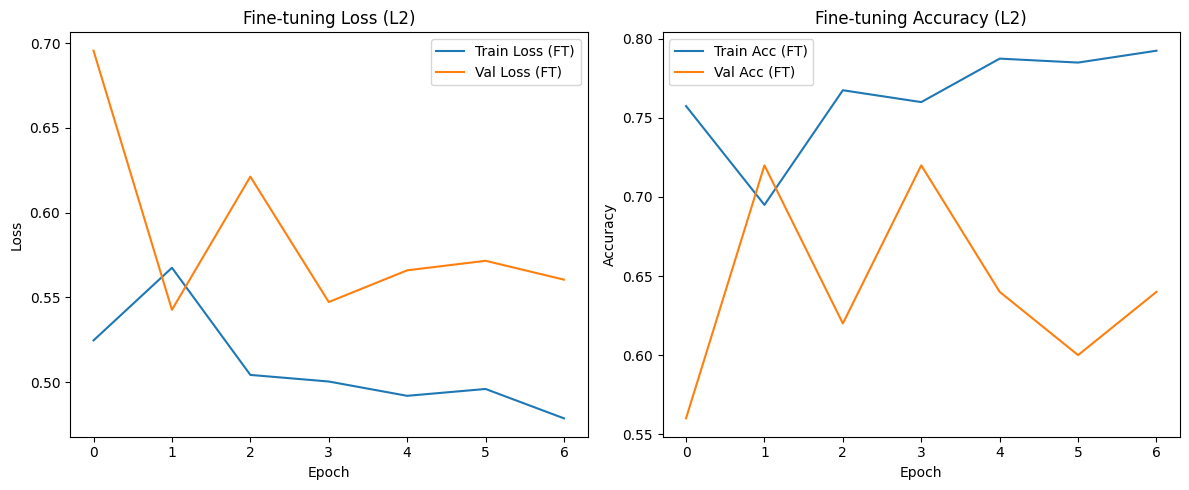

Training history saved successfully.


In [ ]:
"""
From the perspective of the image, the model still has room for improvement, and according to the previous model without L2 regularization,
the model after the first adjustment is the best, so the first fine-tuning is carried out to thaw the last four layers of VGG16
"""

base_model.trainable = True
for layer in base_model.layers[:-4]:
    layer.trainable = False
print("Fine-tuning: Unfreezing the last 4 layers of VGG16.")

#Reduce the learning rate to 1e-5
optimizer_ft = Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer_ft, loss='binary_crossentropy', metrics=['accuracy'])

checkpoint_cb_ft1 = ModelCheckpoint(
    "/content/drive/MyDrive/Colab Notebooks/dh project/director_style_model_ft1_l2.h5",
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)
early_stop_cb_ft1 = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
reduce_lr_cb_ft1 = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

fine_tune_epochs = 15
initial_epoch = len(history_init.epoch)  # 15
total_epochs = initial_epoch + fine_tune_epochs

print(f"===== Start Fine-Tuning from epoch {initial_epoch+1} to {total_epochs} (with L2) =====")
history_ft1 = model.fit(
    train_generator,
    epochs=total_epochs,
    initial_epoch=initial_epoch,
    validation_data=val_generator,
    callbacks=[checkpoint_cb_ft1, early_stop_cb_ft1, reduce_lr_cb_ft1]
)

#Evaluate the model after the first fine-tuning
test_loss_ft, test_acc_ft = model.evaluate(test_generator)
print("Fine-tuned Model (with L2) - Test Loss:", test_loss_ft)
print("Fine-tuned Model (with L2) - Test Accuracy:", test_acc_ft)

#Visual fine-tuning training curve
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_ft1.history['loss'], label='Train Loss (FT)')
plt.plot(history_ft1.history['val_loss'], label='Val Loss (FT)')
plt.title('Fine-tuning Loss (L2)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_ft1.history['accuracy'], label='Train Acc (FT)')
plt.plot(history_ft1.history['val_accuracy'], label='Val Acc (FT)')
plt.title('Fine-tuning Accuracy (L2)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

#Save the history dictionary for subsequent calls
with open("/content/drive/MyDrive/Colab Notebooks/dh project/history_ft1_with_l2.pkl", "wb") as f:
    pickle.dump(history_ft1.history, f)
print("Training history saved successfully.")

In [ ]:
#Check if the model is successfully saved and the summary of the model
model_path = "/content/drive/MyDrive/Colab Notebooks/dh project/director_style_model_ft1_l2.h5"
model = load_model(model_path)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,846,275 (56.63 MB)

 Trainable params: 7,211,009 (27.51 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

 Optimizer params: 2 (12.00 B)

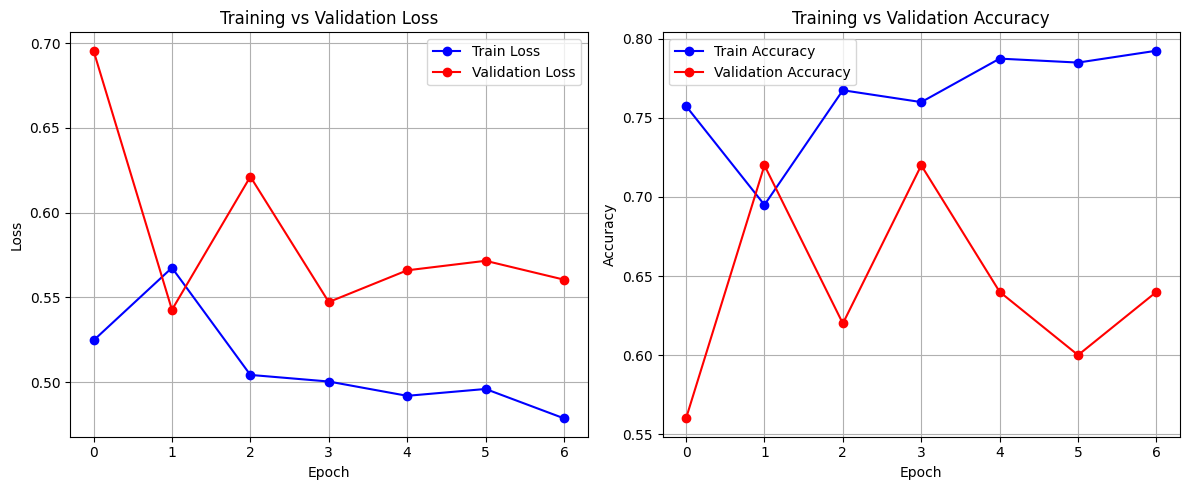

In [ ]:
#Model performance chart (showing training process and confusion matrix)
#Load history_ft1 before
history = history_ft1.history
epochs = range(len(history['loss']))
#Plot training/verification loss and accuracy curves
plt.figure(figsize=(12, 5))

#Loss curve
plt.subplot(1, 2, 1)
plt.plot(epochs, history['loss'], 'bo-', label='Train Loss')
plt.plot(epochs, history['val_loss'], 'ro-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

#Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(epochs, history['accuracy'], 'bo-', label='Train Accuracy')
plt.plot(epochs, history['val_accuracy'], 'ro-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/dh project/model_training_performance.png')
plt.show()


In [ ]:
#Check the previously defined category labels
test_generator.class_indices

{'miyazaki': 0, 'takahata': 1}

2/2 ━━━━━━━━━━━━━━━━━━━━ 31s 10s/step - accuracy: 0.7804 - loss: 0.5910
Test set Loss: 0.5662567019462585
Test set Accuracy: 0.7799999713897705


2/2 ━━━━━━━━━━━━━━━━━━━━ 31s 10s/step
              precision    recall  f1-score   support

    Miyazaki       0.79      0.76      0.78        25
    Takahata       0.77      0.80      0.78        25

    accuracy                           0.78        50
   macro avg       0.78      0.78      0.78        50
weighted avg       0.78      0.78      0.78        50

Confusion Matrix:
 [[19  6]
 [ 5 20]]


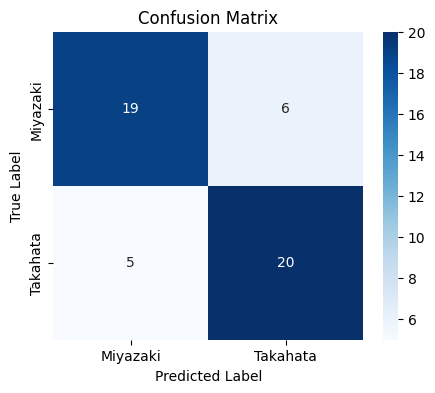

In [ ]:
model = load_model("/content/drive/MyDrive/Colab Notebooks/dh project/director_style_model_ft1_l2.h5")

#Evaluate the accuracy and loss of the final model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test set Loss:", test_loss)
print("Test set Accuracy:", test_accuracy)

#Output classification reports (precision, recall, F1) and confusion matrices
#First get the prediction probability, making sure to start with the 0
test_generator.reset()
y_prob = model.predict(test_generator)
#Switch to binary classification 0/1
y_pred = (y_prob > 0.5).astype('int32').ravel()
y_true = test_generator.classes

#Output a classification report, where 0 represents Miyazaki and 1 represents Takahata
target_names = ['Miyazaki','Takahata']
print(classification_report(y_true, y_pred, target_names=target_names))
#print confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

#Visualize the output
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=target_names,
            yticklabels=target_names)
plt.title("Confusion Matrix")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Number of misclassified samples: 11
Index: 4, File: miyazaki/2-24.png, True: 0, Pred: 1
Index: 5, File: miyazaki/2-27.png, True: 0, Pred: 1
Index: 9, File: miyazaki/2-8.png, True: 0, Pred: 1
Index: 10, File: miyazaki/2-9.png, True: 0, Pred: 1
Index: 19, File: miyazaki/5-14.png, True: 0, Pred: 1
Index: 23, File: miyazaki/5-40.png, True: 0, Pred: 1
Index: 29, File: takahata/10-5.png, True: 1, Pred: 0
Index: 33, File: takahata/6-25.png, True: 1, Pred: 0
Index: 34, File: takahata/6-26.png, True: 1, Pred: 0
Index: 35, File: takahata/6-28.png, True: 1, Pred: 0
File: miyazaki/2-24.png, True: Miyazaki, Predicted: Takahata


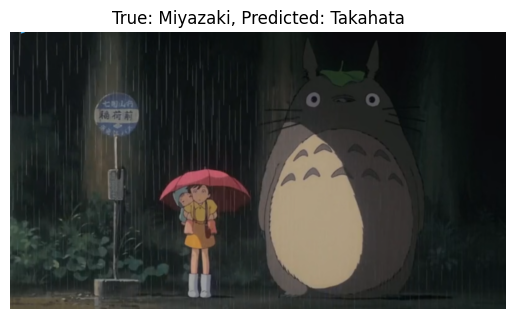

File: miyazaki/2-27.png, True: Miyazaki, Predicted: Takahata


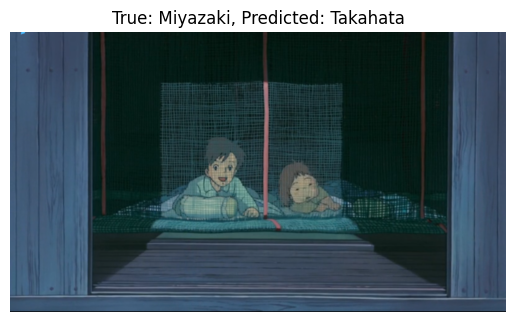

File: miyazaki/2-8.png, True: Miyazaki, Predicted: Takahata


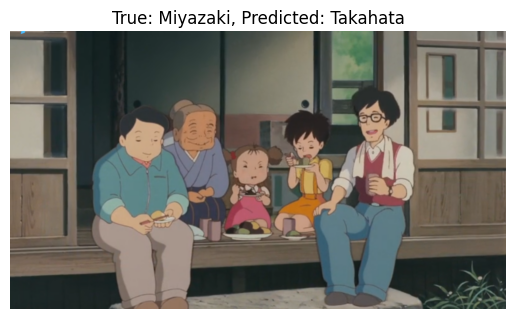

File: miyazaki/2-9.png, True: Miyazaki, Predicted: Takahata


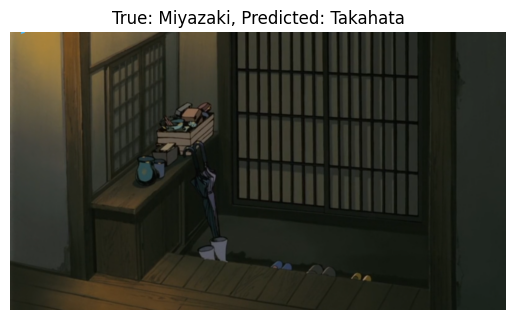

File: miyazaki/5-14.png, True: Miyazaki, Predicted: Takahata


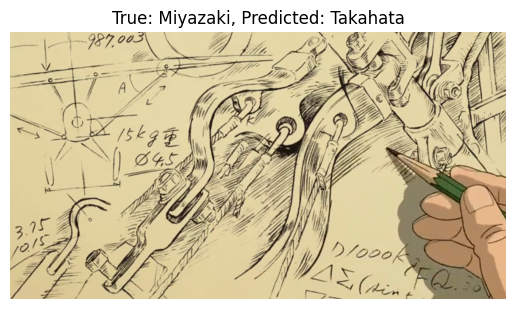

In [ ]:
#Identify misclassified samples and analyze the causes
#Imagedatagenerater.flow_from_directory has a filenames attribute in test_generator
#that records the relative path of each image (for test_dir) and can be used to locate which images are predicted incorrectly.

#list of filenames in the same order as model.predict
filenames = test_generator.filenames
misclassified_indices = np.where(y_pred != y_true)[0]
print("Number of misclassified samples:", len(misclassified_indices))
#Print the first 10 example
for i in misclassified_indices[:10]:
    print(f"Index: {i}, File: {filenames[i]}, True: {y_true[i]}, Pred: {y_pred[i]}")

#View and visualize several misassigned screenshots
mis_files = [filenames[i] for i in misclassified_indices]
#Show the first 5 mismarks
for j in range(5):
    idx = misclassified_indices[j]
    file_path = os.path.join(test_dir, filenames[idx])

    #open the image and print the information
    img = Image.open(file_path)
    true_label = target_names[y_true[idx]]
    pred_label = target_names[y_pred[idx]]
    print(f"File: {filenames[idx]}, True: {true_label}, Predicted: {pred_label}")

    #Visualize the picture
    plt.figure()
    plt.imshow(img)
    plt.title(f"True: {true_label}, Predicted: {pred_label}")
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Image: /content/drive/MyDrive/Colab Notebooks/dh project/dataset/test/takahata/9-37.png
  True label: Takahata
  Pred prob(Miyazaki): 0.9811 => Predict: Takahata
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step
Image: /content/drive/MyDrive/Colab Notebooks/dh project/dataset/test/takahata/10-5.png
  True label: Takahata
  Pred prob(Miyazaki): 0.3814 => Predict: Miyazaki
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step
Image: /content/drive/MyDrive/Colab Notebooks/dh project/dataset/test/miyazaki/3-21.png
  True label: Miyazaki
  Pred prob(Miyazaki): 0.1452 => Predict: Miyazaki
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step
Image: /content/drive/MyDrive/Colab Notebooks/dh project/dataset/test/miyazaki/2-24.png
  True label: Miyazaki
  Pred prob(Miyazaki): 0.6339 => Predict: Takahata


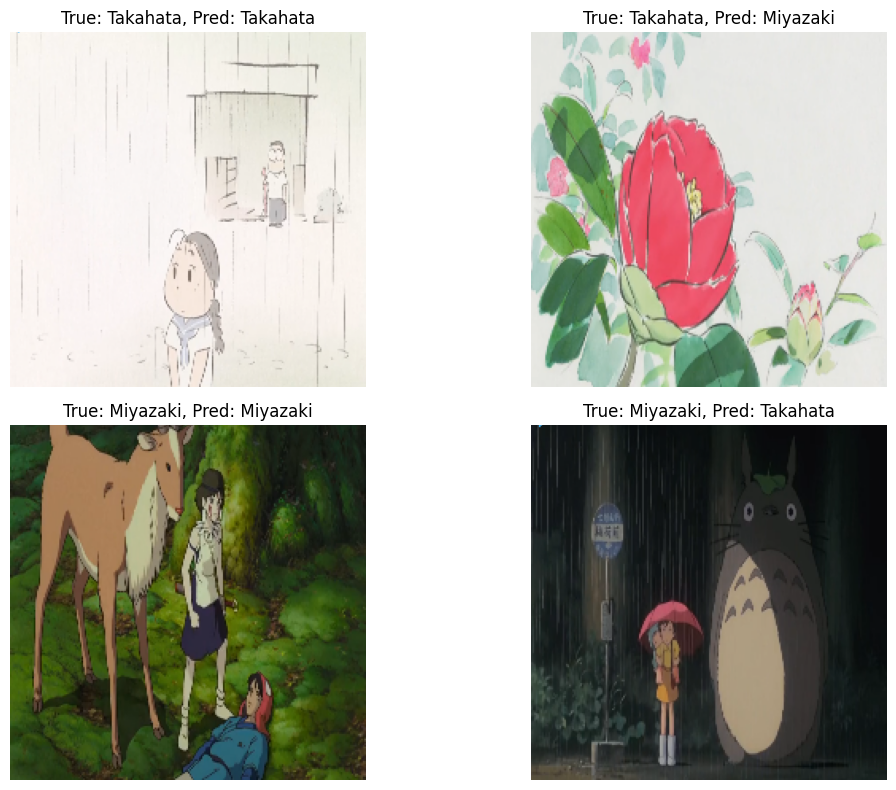

In [ ]:
#Select a few typical cases to analyze, respectively select two groups of models to distinguish between the right and wrong
model = load_model("/content/drive/MyDrive/Colab Notebooks/dh project/director_style_model_ft1_l2.h5")

#Pick two sets of pictures, the one that predicted correctly and the one that predicted incorrectly
#Set the path of the pictures and real director tags (0= Hayao Miyazaki, 1= Isao Takahata)
sample_images = [
    ("/content/drive/MyDrive/Colab Notebooks/dh project/dataset/test/takahata/9-37.png", 1),  #A plain picture of Takahata
    ("/content/drive/MyDrive/Colab Notebooks/dh project/dataset/test/takahata/10-5.png", 1),  #A wrong predicted picture of Takahata
    ("/content/drive/MyDrive/Colab Notebooks/dh project/dataset/test/miyazaki/3-21.png", 0),   #A bright picture of Miyazaki
    ("/content/drive/MyDrive/Colab Notebooks/dh project/dataset/test/miyazaki/2-24.png", 0)   #A wrong predicted picture of Miyazaki
]

#Define image preprocessing and prediction functions
def load_and_preprocess(img_path, target_size=(224,224)):
    #Read and resize with Keras's image tool
    img = image.load_img(img_path, target_size=target_size)
    x = image.img_to_array(img)
    #Use the same rescale as originally defined
    x = x / 255.0
    x = np.expand_dims(x, axis=0)
    #Returns an array and the original PIL image object
    return x, img  #

target_names = ['Miyazaki','Takahata']

#Visual prediction results
plt.figure(figsize=(12, 8))
for i, (img_path, true_label) in enumerate(sample_images):
    x, pil_img = load_and_preprocess(img_path)
    prob = model.predict(x)[0,0]
    pred_label = 1 if prob>0.5 else 0

    #Print the information
    print(f"Image: {img_path}")
    print(f"  True label: {target_names[true_label]}")
    print(f"  Pred prob(Miyazaki): {prob:.4f} => Predict: {target_names[pred_label]}")

    #Show the four pictures
    plt.subplot(2, 2, i+1)
    plt.imshow(pil_img)
    title_str = f"True: {target_names[true_label]}, Pred: {target_names[pred_label]}"
    plt.title(title_str)
    plt.axis('off')

plt.tight_layout()
plt.show()

                 movie     label       hue  brightness  year  order
0   1Castle in the Sky  Miyazaki  0.420419    0.359134  1986      1
1  2My Neighbor Totoro  Miyazaki  0.397149    0.343250  1988      2
2   3Princess Mononoke  Miyazaki  0.437853    0.297152  1997      3
3       4Spirited Away  Miyazaki  0.137874    0.482989  2001      4
4      5The Wind Rises  Miyazaki  0.265418    0.450470  2013      5


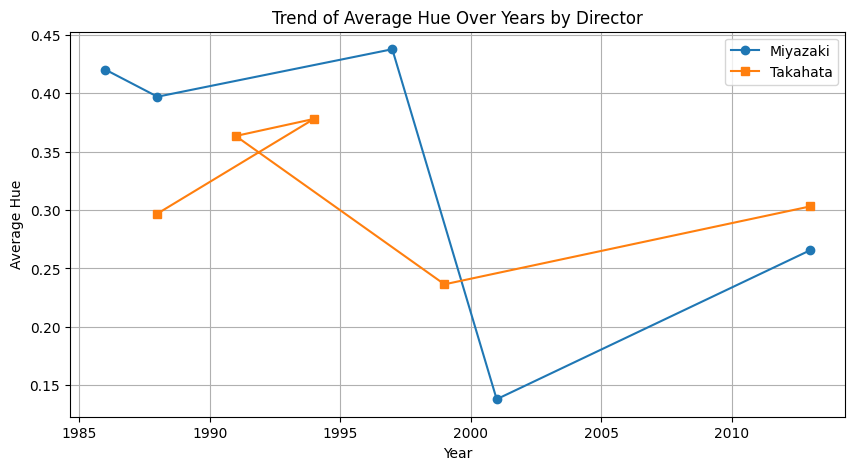

In [ ]:
#Plot the trend of color change over the years
df_color = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dh project/movie_color_stats.csv")
print(df_color.head())

plt.figure(figsize=(10, 5))

# Miyazaki
miyazaki = df_color[df_color['label'] == 'Miyazaki']
plt.plot(miyazaki['year'], miyazaki['hue'], marker='o', label='Miyazaki')

# Takahata
takahata = df_color[df_color['label'] == 'Takahata']
plt.plot(takahata['year'], takahata['hue'], marker='s', label='Takahata')

plt.xlabel('Year')
plt.ylabel('Average Hue')
plt.title('Trend of Average Hue Over Years by Director')
plt.legend()
plt.grid(True)
plt.savefig('color_trend_over_years.png')
plt.show()


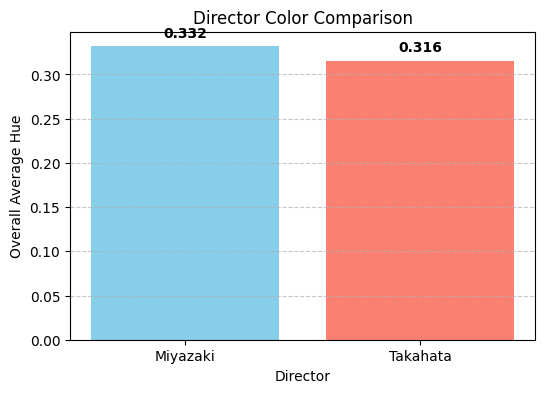

In [ ]:
#Draw the director's tone average contrast map
avg_hues = df_color.groupby('label')['hue'].mean()

plt.figure(figsize=(6, 4))
plt.bar(avg_hues.index, avg_hues.values, color=['skyblue', 'salmon'])
plt.xlabel('Director')
plt.ylabel('Overall Average Hue')
plt.title('Director Color Comparison')
for i, v in enumerate(avg_hues.values):
    plt.text(i, v + 0.01, f"{v:.3f}", ha='center', fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('director_color_comparison.png')
plt.show()
